# Task 1: Predictive Core – Stock Price Forecasting

## Objective
The goal of this task is to develop a forecasting engine that learns from historical stock market data and predicts future price movements while explicitly modeling uncertainty and volatility.  
The system uses statistical time series modeling to analyze trends, seasonality, and momentum in financial assets.

## Dataset
- Source: CSV file containing historical OHLCV (Open, High, Low, Close, Volume) data
- Frequency: Daily stock prices
- Asset: Single stock ticker (can be extended to multiple tickers)

## Tools & Libraries
- Python
- Pandas & NumPy
- Statsmodels (SARIMA)
- Matplotlib
- Scikit-learn


In [66]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from time import time
from datetime import timedelta

## Data Preprocessing

The dataset is first cleaned and prepared for time series analysis.  
Steps include:
- Converting the Date column to datetime format
- Setting Date as the index
- Ensuring a consistent business-day frequency
- Forward-filling missing values

This preprocessing ensures the data is suitable for statistical forecasting models.


In [67]:
aapl_data = yf.download("AAPL", start="2023-01-01", end="2024-01-01")
aapl_data.to_csv("AAPL.csv")

/tmp/ipython-input-2866422547.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl_data = yf.download("AAPL", start="2023-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


In [68]:
aapl_data.tail()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2023-12-22,191.788773,193.581837,191.164662,193.353978,37149600
2023-12-26,191.243912,192.076049,191.025969,191.798670,28919300
2023-12-27,191.342972,191.689703,189.302247,190.689158,48087700
2023-12-28,191.768921,192.838819,191.362753,192.323679,34049900
2023-12-29,190.728760,192.581260,189.936241,192.085938,42672100


In [69]:
aapl_df=pd.read_csv("AAPL.csv")
aapl_df.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
1,Date,NaN,NaN,NaN,NaN,NaN
2,2023-01-03,123.21119689941406,128.9545451464431,122.32457128587431,128.3437644584535,112117500
3,2023-01-04,124.48204040527344,126.7478608503369,123.22106494631889,125.00416235162118,89113600
4,2023-01-05,123.16194152832031,125.87107085400619,122.90581107632524,125.24058317585433,80962700


In [70]:
aapl_df=aapl_df.dropna()
aapl_df.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
2,2023-01-03,123.21119689941406,128.9545451464431,122.32457128587431,128.3437644584535,112117500
3,2023-01-04,124.48204040527344,126.7478608503369,123.22106494631889,125.00416235162118,89113600
4,2023-01-05,123.16194152832031,125.87107085400619,122.90581107632524,125.24058317585433,80962700
5,2023-01-06,127.69359588623047,128.35363661029058,123.03389687582771,124.1372542550979,87754700


In [109]:
aapl_df = pd.read_csv("AAPL.csv", header=[0, 1], index_col=0)
aapl_df.index = pd.to_datetime(aapl_df.index)
aapl_df.index.name = 'date'
aapl_df.columns = [col[1] if col[1] else col[0] for col in aapl_df.columns]
aapl_df = aapl_df.dropna()
aapl_df.head()

,AAPL,AAPL,AAPL,AAPL,AAPL
date,,,,,
2023-01-03,123.211197,128.954545,122.324571,128.343764,112117500
2023-01-04,124.482040,126.747861,123.221065,125.004162,89113600
2023-01-05,123.161942,125.871071,122.905811,125.240583,80962700
2023-01-06,127.693596,128.353637,123.033897,124.137254,87754700
2023-01-09,128.215698,131.427258,127.959568,128.530950,70790800


In [110]:
if 'Close' not in aapl_df.columns:
    expected_columns = ['Close', 'High', 'Low', 'Open', 'Volume']
    if len(aapl_df.columns) == len(expected_columns):
        aapl_df.columns = expected_columns
    else:
        print("Warning: Column count mismatch, cannot auto-rename columns correctly.")
aapl_df['Close'] = pd.to_numeric(aapl_df['Close'], errors='coerce')

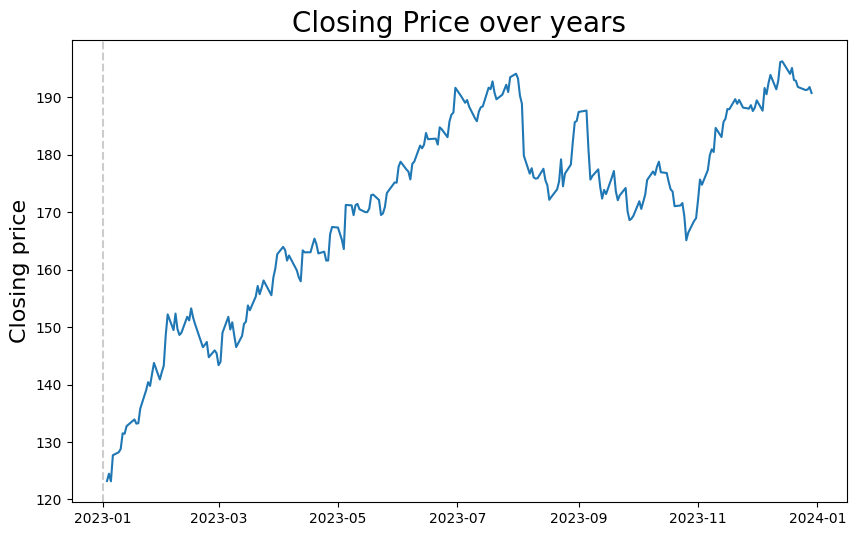

In [75]:
plt.figure(figsize=(10,6))
plt.plot(aapl_df.Close)
plt.title('Closing Price over years', fontsize=20)
plt.ylabel('Closing price', fontsize=16)
for year in range(2023,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [76]:
aapl_first_diff = aapl_df.Close.values[1:] - aapl_df.Close.values[:-1]
aapl_first_diff = np.concatenate([aapl_first_diff, [0]])

In [77]:
aapl_df["FirstDifference"]=aapl_first_diff

In [78]:
aapl_df.head()

,Close,High,Low,Open,Volume,FirstDifference
date,,,,,,
2023-01-03,123.211197,128.954545,122.324571,128.343764,112117500,1.270844
2023-01-04,124.482040,126.747861,123.221065,125.004162,89113600,-1.320099
2023-01-05,123.161942,125.871071,122.905811,125.240583,80962700,4.531654
2023-01-06,127.693596,128.353637,123.033897,124.137254,87754700,0.522102
2023-01-09,128.215698,131.427258,127.959568,128.530950,70790800,0.571381


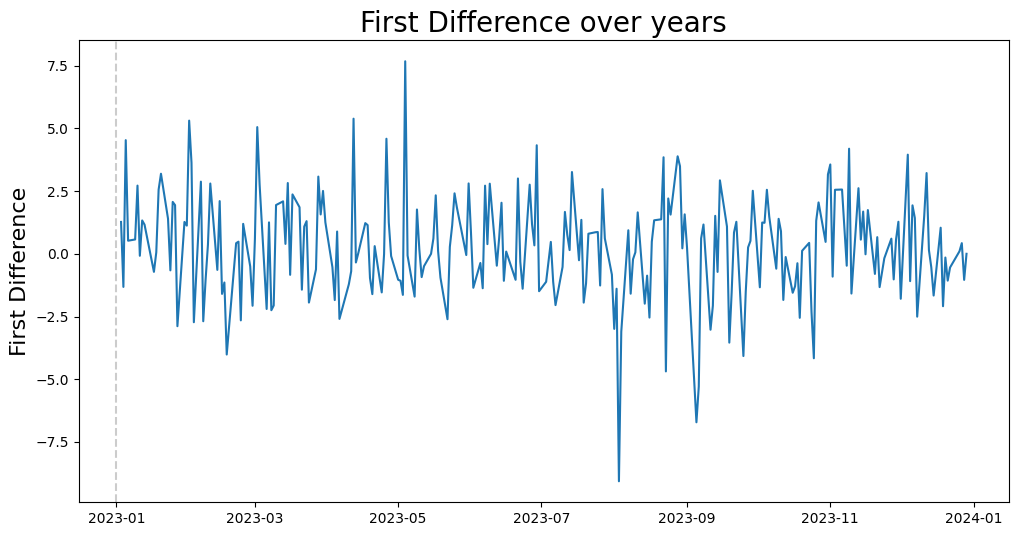

In [79]:
plt.figure(figsize=(12,6))
plt.plot(aapl_df.FirstDifference)
plt.title('First Difference over years', fontsize=20)
plt.ylabel('First Difference', fontsize=16)
for year in range(2023,2024):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

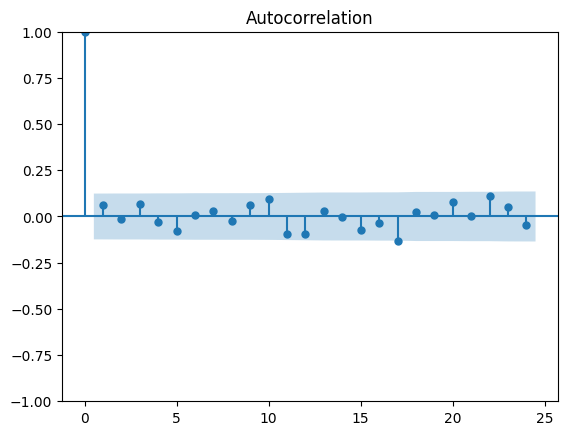

In [80]:
acf_plot = plot_acf(aapl_df.FirstDifference)

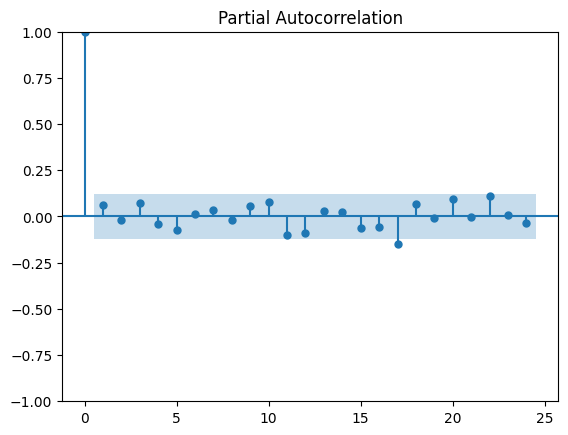

In [81]:
pacf_plot = plot_pacf(aapl_df.FirstDifference)

In [82]:
train_end=datetime(2023,12,23)
test_end=datetime(2024,1,1)

In [83]:
train_data = aapl_df.loc[:train_end, 'FirstDifference'].values
test_data = aapl_df.loc[train_end + timedelta(days=1):test_end, 'FirstDifference'].values

In [111]:
series = aapl_df['Close']

In [90]:
close_series = aapl_df['Close'].asfreq('B')  # Business days
close_series = close_series.fillna(method='ffill')

/tmp/ipython-input-3337840367.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_series = close_series.fillna(method='ffill')


## Model Selection: SARIMA

A Seasonal AutoRegressive Integrated Moving Average (SARIMA) model is used for forecasting.

### Why SARIMA?
- Captures trend through differencing
- Models momentum using autoregressive and moving average terms
- Accounts for weekly seasonality present in stock market data
- Provides probabilistic forecasts with confidence intervals

This makes SARIMA well-suited for financial time series with recurring patterns and volatility.


In [91]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Train-Test Split & Rolling Forecast Validation

To evaluate model performance, the dataset is split into:
- Training set (85%)
- Testing set (15%)

The model is trained on historical data and evaluated on unseen future data to simulate real-world forecasting.  
This rolling forecast validation helps assess generalization ability.


In [100]:
def rolling_sarima_forecast(
    series,
    window=200,
    order=(1,1,1),
    seasonal_order=(0,1,1,5)
):
    predictions = []
    test = series[window:]

    for i in range(window, len(series)):
        history = series[i-window:i]

        model = SARIMAX(
            history,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        model_fit = model.fit(disp=False, maxiter=50)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)

    return test, predictions

In [101]:
train_size = int(len(close_series) * 0.85)
train = close_series[:train_size]
test = close_series[train_size:]

model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(0,1,1,5),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())


                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                  220
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 5)   Log Likelihood                -456.370
Date:                           Wed, 28 Jan 2026   AIC                            920.739
Time:                                   17:48:13   BIC                            934.070
Sample:                               01-03-2023   HQIC                           926.130
                                    - 11-06-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7963      0.120     -6.659      0.000      -1.031      -0.562
ma.L1          0.9007      0.089     10.099

## Model Evaluation Metrics

The forecasting accuracy is evaluated using:

- **RMSE (Root Mean Squared Error):** Measures average prediction error magnitude
- **MAPE (Mean Absolute Percentage Error):** Measures relative prediction accuracy

These metrics are calculated on out-of-sample data to avoid overfitting.


In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

predictions = results.get_forecast(steps=len(test))
pred_mean = predictions.predicted_mean

rmse = np.sqrt(mean_squared_error(test, pred_mean))
mape = mean_absolute_percentage_error(test, pred_mean)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape*100:.2f}%")


RMSE: 10.51
MAPE: 5.27%


## Future Price Forecasting (7 Days)

After validating model performance, the trained SARIMA model is used to forecast stock prices for the next 7 trading days.

In addition to point estimates, confidence intervals are generated to represent prediction uncertainty and market volatility.


In [104]:
forecast_steps = 7
future_forecast = results.get_forecast(steps=forecast_steps)
future_mean = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()


## Confidence Interval Interpretation

The shaded confidence interval represents the range within which future stock prices are expected to lie with a high level of confidence (typically 95%).

- Wider intervals indicate higher uncertainty and volatility
- Narrower intervals indicate greater model confidence

This probabilistic approach is critical for financial forecasting, where uncertainty is inherent.


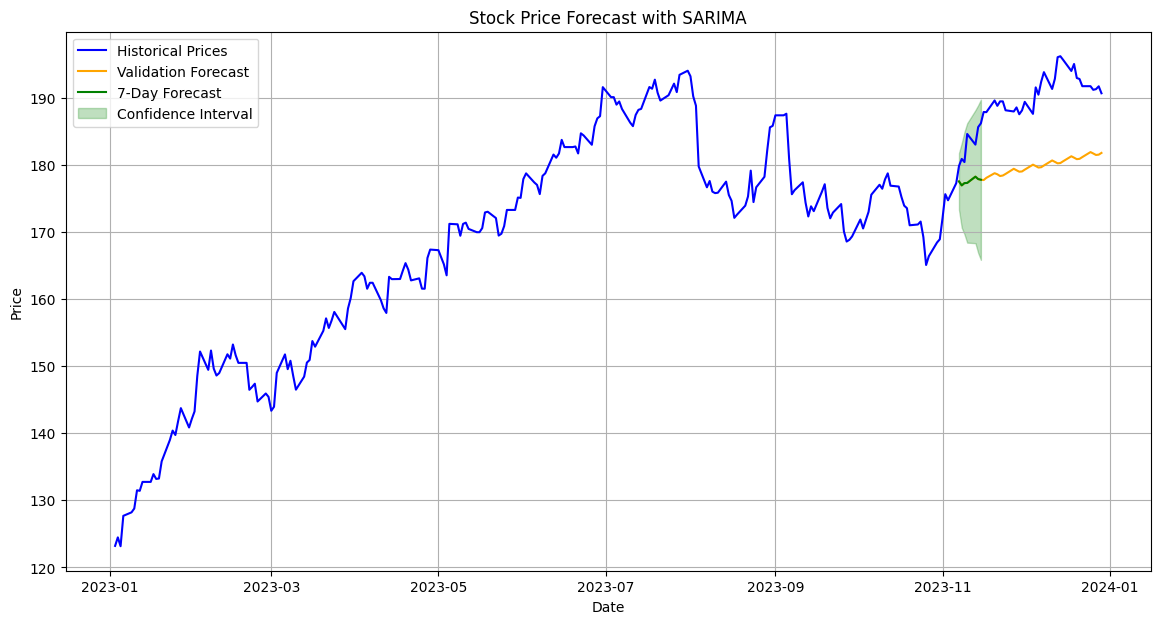

In [107]:
plt.figure(figsize=(14,7))
plt.plot(close_series, label="Historical Prices", color='blue')
plt.plot(pred_mean.index, pred_mean, label="Validation Forecast", color='orange')
plt.plot(future_mean.index, future_mean, label="7-Day Forecast", color='green')

plt.fill_between(
    future_ci.index,
    future_ci.iloc[:, 0],
    future_ci.iloc[:, 1],
    color='green',
    alpha=0.25,
    label="Confidence Interval"
)

plt.title("Stock Price Forecast with SARIMA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


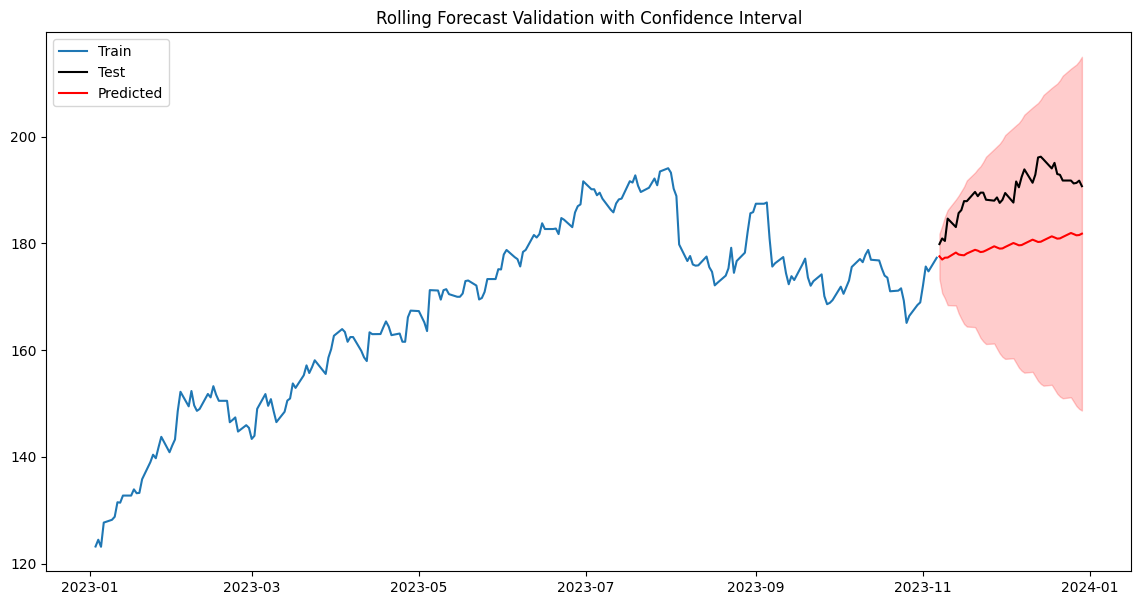

In [108]:
pred_ci = predictions.conf_int()

plt.figure(figsize=(14,7))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", color='black')
plt.plot(pred_mean.index, pred_mean, label="Predicted", color='red')

plt.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color='red',
    alpha=0.2
)

plt.title("Rolling Forecast Validation with Confidence Interval")
plt.legend()
plt.show()


## Conclusion

A statistical forecasting engine was successfully developed using a SARIMA model to predict future stock price movements.

Key outcomes:
- Historical trends and seasonal patterns were captured effectively
- Forecasts were generated for both past validation periods and future horizons
- Uncertainty and volatility were explicitly modeled using confidence intervals
- Model performance was evaluated using RMSE and MAPE

### Limitations & Future Work
- SARIMA assumes linear relationships and may struggle with sudden market shocks
- Future improvements may include LSTM or Transformer-based models
- Multi-ticker and macroeconomic features can be incorporated for enhanced accuracy
